In [1]:
from astropy.io import fits
from astropy import units, constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
from voigt_fit_lib import *
import os
import pickle

Load in the files

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/'

Then, the HIRES files

In [7]:
spec_fits_hires = fits.open(rootdir + 'HIRES/PG1522+101_HIRES.fits')
lsf_fits_hires = fits.open(rootdir + 'HIRES/PG1522_HIRES_wavcal2023_lsf.fits')

Transition info

In [8]:
wav0_rest = 1548.2049
f = 0.1899
gamma = 0.040903573458000005
A = 12.011

In [9]:
wav = pd.DataFrame(spec_fits_hires[1].data).to_numpy()[:,0]

Functions

In [10]:
def grab_ion_transition_lsf(z_abs):

    # Convert it to an array
    lsf_data = np.array(lsf_fits_hires[1].data)

    # For each wavelength, isolate LSFs
    lsf_wavs = []

    for i in range(len(lsf_data)):
        lsf_wavs.append(lsf_data[i][0])

    lsf_wavs = np.array(lsf_wavs)

    # Isolate the closest LSF
    lsf_idx = np.argmin(np.abs(wav0_rest*(1+z_abs)-lsf_wavs))
    lsf = lsf_data[lsf_idx][2]

    # Also generate the velocity scale corresponding to the LSF
    delta_v = lsf_data[lsf_idx][1]
    lsf_central_idx = np.argmax(lsf)
    lsf_pix_rel = np.arange(0, len(lsf))-lsf_central_idx
    lsf_pix_v = delta_v*lsf_pix_rel

    # Finally store the LSF velocities and the profile itself
    return lsf, lsf_pix_v

In [11]:
def vp(z_abs, params, lsf_convolve=True):
    
    # Grab LSF
    lsf, lsf_pix_v = grab_ion_transition_lsf(z_abs)
    
    # Get velocities
    wav0_obs = wav0_rest*(1+z_abs)
    v = c*(wav-wav0_obs)/wav0_obs
    idx = (v>=-300)&(v<=300)
    v = v[idx]
    
    model = comp_model_spec_gen(v, params, 
                                wav0_rest, f, gamma, A,
                                True,
                                lsf, lsf_pix_v)[1]
    
    return v, model

# z = 1.04431

In [12]:
z_sys = 1.04430803

In [13]:
v, m = vp(z_sys, [[13.64,6.7,0.],[13.37,6.3,40.],[13.45, 10., 79.5], [13.53, 8.3, 100.5]])

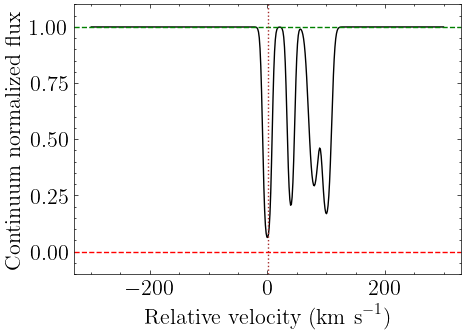

In [24]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

Compute equivalent width

In [29]:
def get_EW(v, flux, v_min=-200, v_max=200):

    idx = (v>v_min)&(v<v_max)

    v_abs = v[idx]
    flux_abs = flux[idx][:-1]

    delta_lambda = np.mean(((v_abs[1:]-v_abs[:-1])*wav0_rest/3e+5)*1e+3) # in mA

    EW = np.sum((1-flux_abs)*delta_lambda)

    return EW

In [41]:
get_EW(v, m)

288.77038922986605

Do a monte carlo computation

In [39]:
N_trials = 100
params_grid = np.zeros((N_trials, 4*3))

Generate parameter realizations 

In [42]:
logN_c1 = np.random.normal(13.64, 0.02, N_trials)
b_c1 = np.random.normal(6.7, 0.2, N_trials)
v_c1 = np.random.normal(0.0, 0.2, N_trials)

logN_c2 = np.random.normal(13.37, 0.02, N_trials)
b_c2 = np.random.normal(6.3, 0.3, N_trials)
v_c2 = np.random.normal(40.0, 0.2, N_trials)

logN_c3 = np.random.normal(13.45, 0.04, N_trials)
b_c3 = np.random.normal(10, 1, N_trials)
v_c3 = np.random.normal(79.5, 0.4, N_trials)

logN_c4 = np.random.normal(13.53, 0.03, N_trials)
b_c4 = np.random.normal(8.3, 0.5, N_trials)
v_c4 = np.random.normal(100.5, 0.4, N_trials)

Store in the grid

In [43]:
params_grid[:,0] = logN_c1
params_grid[:,1] = b_c1
params_grid[:,2] = v_c1

params_grid[:,3] = logN_c2
params_grid[:,4] = b_c2
params_grid[:,5] = v_c2

params_grid[:,6] = logN_c3
params_grid[:,7] = b_c3
params_grid[:,8] = v_c3

params_grid[:,9] = logN_c4
params_grid[:,10] = b_c4
params_grid[:,11] = v_c4

Check a realization to ensure numbers are stored correctly

In [47]:
params_grid[0,:].reshape(4,3)

array([[ 13.63129323,   6.49176908,   0.30258442],
       [ 13.33428116,   6.37979797,  40.31842443],
       [ 13.39097206,  10.17806123,  79.81186301],
       [ 13.50300308,   8.114548  , 100.11107949]])

In [56]:
model_grid = []

for i in range(N_trials):
    model_grid.append(vp(z_sys, params_grid[i,:].reshape(4,3))[1])
    
model_grid = np.array(model_grid)

In [63]:
model_hi = np.percentile(model_grid, 100*cdf_1sig, axis=0)
model_lo = np.percentile(model_grid, 100*(1-cdf_1sig), axis=0)

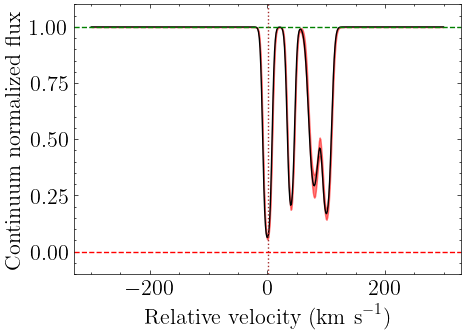

In [67]:
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(v,m)
ax.fill_between(v, model_lo, model_hi, color='red', alpha=.5)

ax.set_xlabel(r'Relative velocity ($\mathrm{km \ s}^{-1}$)')
ax.set_ylabel(r'Continuum normalized flux')
ax.set_ylim(-0.1,1.1)
ax.axhline(0, linestyle='--', color='red')
ax.axhline(1, linestyle='--', color='green')
ax.axvline(1, linestyle=':', color='brown')

In [71]:
model_grid[0,:].shape

(462,)

Get EW distribution

In [72]:
EW_dist = np.zeros(N_trials)

for i in range(N_trials):
    EW_dist[i] = get_EW(v, model_grid[i,:])

In [78]:
np.median(EW_dist), np.median(EW_dist)-np.percentile(EW_dist, 100*(1-cdf_1sig)), np.percentile(EW_dist, 100*cdf_1sig)-np.median(EW_dist)

(287.9660552813285, 6.255054350776618, 6.165113436203569)